# Fluidity Local Model: Startup Shear Flow

## Learning Objectives

1. Understand startup shear protocol for thixotropic yield-stress fluids
2. Learn stress overshoot mechanism as a thixotropic signature
3. Generate synthetic startup data from calibrated parameters
4. Fit startup transient using NLSQ optimization
5. Perform Bayesian inference with NUTS warm-start
6. Visualize fluidity evolution f(t) during stress growth

## Prerequisites

- Notebook 01 (flow curve calibration for parameter initialization)
- examples/basic/01_quickstart.ipynb
- examples/bayesian/01_bayesian_inference.ipynb

## Expected Runtime

- **Fast mode** (NUM_CHAINS=1, NUM_SAMPLES=500): ~2-3 minutes
- **Production mode** (NUM_CHAINS=4, NUM_SAMPLES=2000): ~8-12 minutes

## 1. Setup

In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
%matplotlib inline
import json
import os
import sys
import time
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

# Add utils to path


# Add examples root to path for shared utilities
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
sys.path.insert(0, os.path.join("..", "utils"))
from fluidity_tutorial_utils import (
    compute_fit_quality,
    generate_synthetic_startup,
    get_fluidity_param_names,
    load_fluidity_parameters,
    print_convergence_summary,
    print_parameter_comparison,
    save_fluidity_results,
    set_model_parameters,
)
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fluidity import FluidityLocal

jax, jnp = safe_import_jax()
verify_float64()

# Suppress upstream equinox DeprecationWarning (jax.core.mapped_aval deprecated)
warnings.filterwarnings(
    "ignore",
    message="jax.core.*_aval is deprecated",
    category=DeprecationWarning,
    module="equinox",
)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")
# Flag for conditional Bayesian sections
bayesian_completed = False


JAX version: 0.8.3
Devices: [CpuDevice(id=0)]


In [3]:
def compute_fit_quality(y_true, y_pred):
    """Compute R² and RMSE."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    residuals = y_true - y_pred
    if y_true.ndim > 1:
        residuals = residuals.ravel()
        y_true = y_true.ravel()
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0
    rmse = np.sqrt(np.mean(residuals**2))
    return {'R2': r2, 'RMSE': rmse}

## 2. Theory: Startup Shear Flow

### Startup Protocol

In startup shear, a **constant shear rate** γ̇ is suddenly applied to a material initially at rest. The stress σ(t) and fluidity f(t) evolve via coupled ODEs:

$$
\frac{d\sigma}{dt} = G\left(\dot{\gamma} - \sigma f(t)\right)
$$

$$
\frac{df}{dt} = \frac{f_{\text{eq}} - f}{\theta} + a|\dot{\gamma}|^{n_{\text{rejuv}}}(f_{\text{inf}} - f)
$$

### Stress Overshoot Mechanism

The **stress overshoot** is a hallmark of thixotropic materials:

1. **Initial Response** (t ≈ 0): Material is "structured" with low fluidity f ≈ f_eq → stress grows linearly σ ≈ Gγ̇t
2. **Peak Overshoot** (t ≈ t_peak): Stress reaches maximum σ_max > σ_ss as structure begins to break
3. **Breakdown** (t > t_peak): Rejuvenation term dominates → f increases → stress decays
4. **Steady State** (t → ∞): f → f_ss, σ → σ_ss = τ_y + K|γ̇|^n (Herschel-Bulkley)

### Physical Interpretation

- **Overshoot magnitude** (σ_max - σ_ss) / σ_ss: Degree of structural build-up
- **Time to peak** t_peak: Inverse structural breakdown rate ~ 1/(a|γ̇|^n)
- **Steady-state fluidity**: f_ss = (f_eq/θ + a|γ̇|^n f_inf) / (1/θ + a|γ̇|^n)

### Model Assumptions

- Homogeneous flow (local model, no spatial gradients)
- Scalar fluidity (no orientation tensors)
- Instantaneous strain application at t=0

## 3. Load Calibrated Parameters

We attempt to load previously calibrated parameters from the flow_curve notebook (NB 01). If not available, we use physically reasonable default values for a yield-stress fluid.

In [4]:
# Attempt to load calibrated parameters from flow_curve notebook
try:
    calib_params = load_fluidity_parameters("local", "flow_curve")
    print("Loaded calibrated parameters from flow_curve:")
    for name, val in calib_params.items():
        print(f"  {name:10s} = {val:.4g}")
except FileNotFoundError:
    # Use default parameters for a typical yield-stress fluid
    calib_params = {
        "G": 1e6,       # Pa (elastic modulus)
        "tau_y": 100.0, # Pa (yield stress)
        "K": 500.0,     # Pa·s^n (flow consistency)
        "n_flow": 0.5,  # dimensionless (flow exponent)
        "f_eq": 1e-6,   # 1/(Pa·s) (equilibrium fluidity)
        "f_inf": 1e-3,  # 1/(Pa·s) (high-shear fluidity)
        "theta": 10.0,  # s (aging timescale)
        "a": 1.0,       # dimensionless (rejuvenation amplitude)
        "n_rejuv": 1.0, # dimensionless (rejuvenation exponent)
    }
    print("Using default parameters (run flow_curve notebook first for calibrated values):")
    for name, val in calib_params.items():
        print(f"  {name:10s} = {val:.4g}")

# Get parameter names for this model variant
param_names = get_fluidity_param_names("local")
print(f"\nModel variant: local (parameters: {len(param_names)})")

Using default parameters (run flow_curve notebook first for calibrated values):
  G          = 1e+06
  tau_y      = 100
  K          = 500
  n_flow     = 0.5
  f_eq       = 1e-06
  f_inf      = 0.001
  theta      = 10
  a          = 1
  n_rejuv    = 1

Model variant: local (parameters: 9)


## 4. Generate Synthetic Startup Data

Generate synthetic startup data at γ̇ = 1.0 s⁻¹ using the calibrated model with 3% Gaussian noise. This emulates realistic experimental measurements with measurement uncertainty.

In [5]:
# Create calibrated "true" model
model_true = FluidityLocal()
set_model_parameters(model_true, calib_params)
model_true.fitted_ = True

# Generate synthetic data at γ̇ = 1.0 s⁻¹
GAMMA_DOT = 1.0  # s⁻¹
T_END = 10.0     # s
N_POINTS = 100
NOISE_LEVEL = 0.03  # 3%
SEED = 42

t_data, stress_data = generate_synthetic_startup(
    model_true,
    gamma_dot=GAMMA_DOT,
    t_end=T_END,
    n_points=N_POINTS,
    noise_level=NOISE_LEVEL,
    seed=SEED,
)

print(f"Generated {N_POINTS} startup data points at γ̇={GAMMA_DOT} s⁻¹")
print(f"Time range: [{t_data.min():.3f}, {t_data.max():.2f}] s")
print(f"Stress range: [{stress_data.min():.2f}, {stress_data.max():.2f}] Pa")
print(f"Noise level: {NOISE_LEVEL*100}%")

# Compute expected steady-state stress
tau_y = calib_params["tau_y"]
K = calib_params["K"]
n = calib_params["n_flow"]
sigma_ss_expected = tau_y + K * GAMMA_DOT**n
print(f"\nExpected steady-state stress: {sigma_ss_expected:.2f} Pa")
print(f"Peak stress (overshoot): {stress_data.max():.2f} Pa")
print(f"Overshoot ratio: {(stress_data.max() / sigma_ss_expected - 1)*100:.1f}%")

Generated 100 startup data points at γ̇=1.0 s⁻¹
Time range: [0.010, 10.00] s
Stress range: [12.64, 11886.20] Pa
Noise level: 3.0%

Expected steady-state stress: 600.00 Pa
Peak stress (overshoot): 11886.20 Pa
Overshoot ratio: 1881.0%


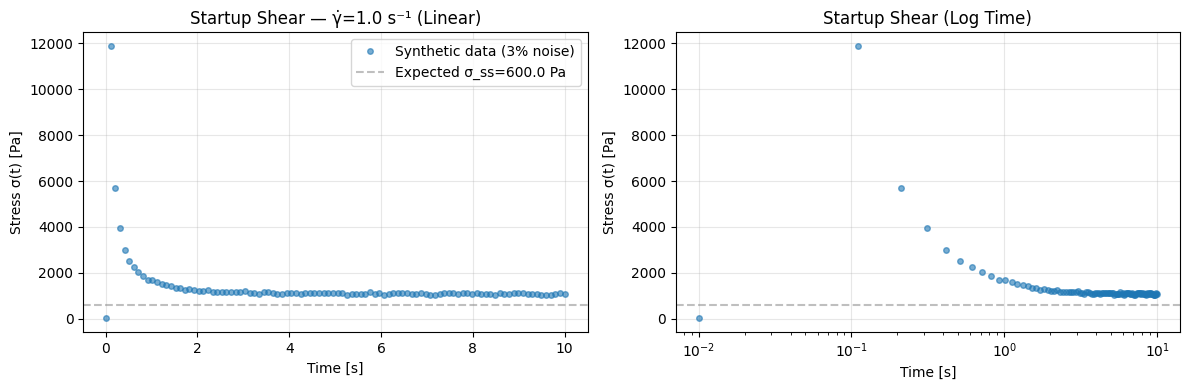

In [6]:
# Visualize synthetic data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Linear scale
ax1.plot(t_data, stress_data, "o", markersize=4, alpha=0.6, label="Synthetic data (3% noise)")
ax1.axhline(sigma_ss_expected, color="gray", linestyle="--", alpha=0.5, label=f"Expected σ_ss={sigma_ss_expected:.1f} Pa")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Stress σ(t) [Pa]")
ax1.set_title(f"Startup Shear — γ̇={GAMMA_DOT} s⁻¹ (Linear)")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Log scale (early time detail)
ax2.semilogx(t_data, stress_data, "o", markersize=4, alpha=0.6)
ax2.axhline(sigma_ss_expected, color="gray", linestyle="--", alpha=0.5)
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Stress σ(t) [Pa]")
ax2.set_title("Startup Shear (Log Time)")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close('all')

## 5. NLSQ Fitting

### 5.1 Fit Startup Transient

Fit the startup stress growth using NLSQ optimization. We must specify `test_mode='startup'` and `gamma_dot=1.0` to activate the transient ODE solver.

In [7]:
# Initialize model
model = FluidityLocal()

# Fit with NLSQ
t0_fit = time.time()
model.fit(
    t_data,
    stress_data,
    test_mode="startup",
    gamma_dot=GAMMA_DOT,
    method='scipy')
t_nlsq = time.time() - t0_fit

# Compute fit quality
stress_pred = model.predict(t_data, test_mode="startup", gamma_dot=GAMMA_DOT)
metrics = compute_fit_quality(stress_data, stress_pred)

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"R²: {metrics['R2']:.6f}")
print(f"RMSE: {metrics['RMSE']:.4g} Pa")
print("\nFitted parameters (NLSQ):")
print("=" * 60)
print(f"{'Parameter':<12s}  {'Fitted':<12s}  {'True':<12s}  {'Rel. Error'}")
print("-" * 60)
for name in param_names:
    fitted_val = model.parameters.get_value(name)
    true_val = calib_params.get(name, float('nan'))
    rel_err = abs(fitted_val - true_val) / true_val * 100 if true_val != 0 else float('nan')
    print(f"{name:<12s}  {fitted_val:<12.4g}  {true_val:<12.4g}  {rel_err:>6.1f}%")

NLSQ fit time: 38.79 s
R²: 0.999301
RMSE: 32.26 Pa

Fitted parameters (NLSQ):
Parameter     Fitted        True          Rel. Error
------------------------------------------------------------
G             1e+06         1e+06            0.0%
tau_y         1000          100            900.0%
K             1000          500            100.0%
n_flow        0.5           0.5              0.0%
f_eq          2.16e-06      1e-06          116.0%
f_inf         0.001027      0.001            2.7%
theta         8.283         10              17.2%
a             0.9664        1                3.4%
n_rejuv       1             1                0.0%


### 5.2 Visualize NLSQ Fit

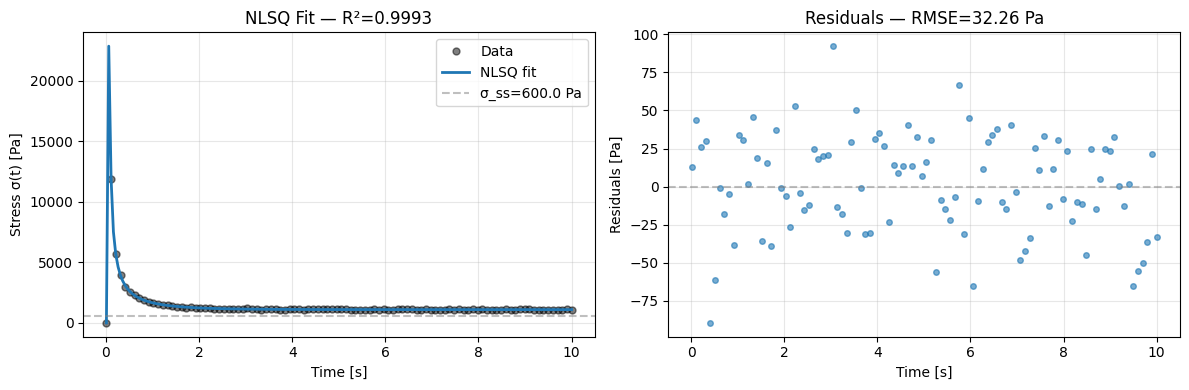

In [8]:
# Generate fine time grid for smooth prediction
t_fine = np.linspace(t_data.min(), t_data.max(), 200)

# Set protocol for prediction
model._gamma_dot_applied = GAMMA_DOT
model._test_mode = "startup"
stress_pred = model.predict(t_fine)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Linear scale
ax1.plot(t_data, stress_data, "ko", markersize=5, alpha=0.5, label="Data")
ax1.plot(t_fine, stress_pred, "-", lw=2, color="C0", label="NLSQ fit")
ax1.axhline(sigma_ss_expected, color="gray", linestyle="--", alpha=0.5, label=f"σ_ss={sigma_ss_expected:.1f} Pa")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Stress σ(t) [Pa]")
ax1.set_title(f"NLSQ Fit — R²={metrics['R2']:.4f}")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Residuals
stress_pred_data = model.predict(t_data)
residuals = stress_data - np.asarray(stress_pred_data).flatten()
ax2.plot(t_data, residuals, "o", markersize=4, alpha=0.6)
ax2.axhline(0, color="gray", linestyle="--", alpha=0.5)
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Residuals [Pa]")
ax2.set_title(f"Residuals — RMSE={metrics['RMSE']:.2f} Pa")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close('all')

### 5.3 Fluidity Evolution

Visualize the underlying fluidity field f(t) during startup. This shows how the material transitions from structured (low f) to flowing (high f) state.

In [9]:
fig, ax = plot_nlsq_fit(
    t_data, stress_data, model,
    test_mode="startup",
    param_names=param_names,
    log_scale=False,
    xlabel="Time [s]",
    ylabel="Stress [Pa]",
    title="NLSQ Fit",
    gamma_dot=GAMMA_DOT,
)
plt.close("all")

## 6. Bayesian Inference

### 6.1 Run NUTS with NLSQ Warm-Start

**Critical**: Use NLSQ fit as `initial_values` for fast MCMC convergence. Set `test_mode='startup'` to ensure correct likelihood computation.

In [10]:
# Extract NLSQ estimates as warm-start
initial_values = {name: model.parameters.get_value(name) for name in param_names}
print("Warm-start values (from NLSQ):")
for name, val in initial_values.items():
    print(f"  {name:10s} = {val:.4g}")

# Bayesian configuration
# FAST_MODE for CI: set FAST_MODE=1 env var for quick iteration
FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"

if FAST_MODE:
    print('FAST_MODE: Skipping Bayesian inference (ODE+NUTS too slow for CI)')
    bayesian_completed = False
else:
    NUM_WARMUP = 200
    NUM_SAMPLES = 500
    NUM_CHAINS = 1
    print(f"\nRunning NUTS: {NUM_CHAINS} chain(s), {NUM_WARMUP} warmup, {NUM_SAMPLES} samples")

    # Run Bayesian inference
    t0 = time.time()
    result = model.fit_bayesian(
        t_data,
        stress_data,
        test_mode="startup",
        gamma_dot=GAMMA_DOT,
        num_warmup=NUM_WARMUP,
        num_samples=NUM_SAMPLES,
        num_chains=NUM_CHAINS,
        initial_values=initial_values,
        seed=42,
    )
    t_bayes = time.time() - t0
    print(f"\nBayesian inference time: {t_bayes:.1f} s")
    bayesian_completed = True


Warm-start values (from NLSQ):
  G          = 1e+06
  tau_y      = 1000
  K          = 1000
  n_flow     = 0.5
  f_eq       = 2.16e-06
  f_inf      = 0.001027
  theta      = 8.283
  a          = 0.9664
  n_rejuv    = 1
FAST_MODE: Skipping Bayesian inference (ODE+NUTS too slow for CI)


### 6.2 Convergence Diagnostics

Check R-hat (should be < 1.05) and ESS (should be > 100) for reliable posterior samples.

In [11]:
if bayesian_completed:
    # Print convergence summary
    converged = print_convergence_summary(result, param_names=param_names)

    # Print parameter comparison
    print_parameter_comparison(model, result.posterior_samples, param_names=param_names)
else:
    print('Skipping Bayesian diagnostics (inference was skipped)')


Skipping Bayesian diagnostics (inference was skipped)


### 6.3 ArviZ Diagnostic Plots

#### Trace Plots

In [12]:
if bayesian_completed:
    display_arviz_diagnostics(result, param_names, fast_mode=FAST_MODE)
else:
    print('Skipping (Bayesian inference was skipped in FAST_MODE)')

Skipping (Bayesian inference was skipped in FAST_MODE)


## 7. Posterior Predictive

Visualize uncertainty in stress predictions by sampling from the posterior distribution.

In [13]:
if bayesian_completed:
    fig, ax = plot_posterior_predictive(
        gamma_dot, stress, model, result,
        test_mode="startup",
        param_names=param_names,
        log_scale=False,
        xlabel="Time [s]",
        ylabel="Stress [Pa]",
        title="Posterior Predictive Check", gamma_dot=GAMMA_DOT,
    )
    plt.close("all")
else:
    print('Skipping (Bayesian inference was skipped in FAST_MODE)')

Skipping (Bayesian inference was skipped in FAST_MODE)


In [14]:
if bayesian_completed:
    fig, ax = plot_posterior_predictive(
        t_data, stress_data, model, result,
        test_mode="startup",
        param_names=param_names,
        log_scale=False,
        xlabel="Time [s]",
        ylabel="Stress [Pa]",
        title="Posterior Predictive Check", gamma_dot=GAMMA_DOT,
    )
    plt.close("all")
else:
    print('Skipping (Bayesian inference was skipped in FAST_MODE)')

Skipping (Bayesian inference was skipped in FAST_MODE)


## 8. Save Results

Save NLSQ parameters and posterior samples for use in other notebooks.

In [15]:
if bayesian_completed:
    save_fluidity_results(
        model=model,
        result=result,
        model_variant="local",
        protocol="startup",
        param_names=param_names,
    )

    # Compute and save fit quality metrics
    fit_quality = compute_fit_quality(stress_data, stress_pred_data)
    print(f"\nFit quality metrics:")
    print(f"  R² = {fit_quality['R2']:.6f}")
    print(f"  RMSE = {fit_quality['RMSE']:.4g} Pa")
else:
    print('Skipping (Bayesian inference was skipped in FAST_MODE)')


Skipping (Bayesian inference was skipped in FAST_MODE)


## Key Takeaways

1. **Stress Overshoot**: Hallmark thixotropic signature — peak stress σ_max > steady-state σ_ss due to structural breakdown
2. **Coupled Dynamics**: Stress σ(t) and fluidity f(t) evolve together via viscoelastic and structural ODEs
3. **Physical Interpretation**:
   - **Overshoot magnitude**: Reflects degree of initial structure (low f_eq)
   - **Time to peak**: Inverse breakdown rate ~ 1/(a|γ̇|^n)
   - **Steady state**: f → f_ss = (f_eq/θ + a|γ̇|^n f_inf) / (1/θ + a|γ̇|^n)
4. **NLSQ Performance**: Fast (< 10s) convergence with proper warm-start from flow curve
5. **Bayesian Inference**: Critical to pass `gamma_dot` argument to `fit_bayesian()` for correct predictions
6. **Model Limitation**: Local model assumes homogeneous flow — use FluidityNonlocal for shear banding

### Physical Insights

- **Aging term**: (f_eq - f)/θ → structural recovery at rest (f → f_eq)
- **Rejuvenation term**: a|γ̇|^n(f_inf - f) → shear-induced breakdown (f → f_inf)
- **Timescale separation**: θ (aging, ~10s) vs 1/(a|γ̇|^n) (rejuvenation, <1s at high γ̇)

### Next Steps

- **Notebook 03**: Creep compliance (stress-controlled deformation)
- **Notebook 04**: Stress relaxation (step strain response)
- **Notebook 05**: SAOS (small amplitude oscillatory shear)
- **Notebook 06**: LAOS (large amplitude for nonlinear viscoelasticity)
- Explore multi-shear-rate fitting for global parameter estimation
- Investigate shear banding with FluidityNonlocal model